# Initial QPE Circuit Bayesian version.

In [19]:
# Importing libraries.
from pytket.circuit import Circuit
from pytket.circuit import CircBox
from pytket.circuit import QControlBox
from pytket.circuit.display import render_circuit_jupyter

In [20]:
from math import log2
from pytket.passes import DecomposeBoxes
import numpy as np

In [79]:
from pytket.extensions.nexus import NexusBackend, QuantinuumConfig, Nexus
from datetime import datetime
from pytket.extensions.qiskit import AerBackend

In [22]:
class bayesian_qpe_builder():
    
    def __init__(self, in_qubits, m_qubits, input_angle=1, z_angle=0, m=0):
        # Initializing the circuit.
        self.bayesian_qpe_circ: Circuit = Circuit()

        # Variables.
        self.m = m
        self.in_qubits = in_qubits
        self.m_qubits = m_qubits
        self.input_angle = input_angle
        self.z_angle = z_angle
        
        # Creating the initial qubits.
        initial_state = Circuit(in_qubits).X(0)  # Initial state of the circuit (|psi>).

        # Creating the unitary gate.
        unitary_control = Circuit(m_qubits).U1(input_angle, 0)  # Unitary control gate.
        unitary_control.name = "U"
        controlled_u_gate = QControlBox(CircBox(unitary_control), 1)
        
        # Initiate the measurement qubit.
        measurement_register = self.bayesian_qpe_circ.add_q_register("|0>", m_qubits)
        # Initiate the initial state.
        state_prep_register = self.bayesian_qpe_circ.add_q_register("psi", in_qubits)

        # Adding tha Hadamard gate.
        for m_qubit in measurement_register:
            self.bayesian_qpe_circ.H(m_qubit)

        # Build the circuit.
        self.bayesian_qpe_circ.add_circuit(initial_state, list(state_prep_register))
        
        # Adding the U-Control gate.
        for m_qubit in range(m_qubits):
            control_index = m_qubits - m_qubit - 1 # Contrtoling the index of the qubit.
            control_qubit = [measurement_register[control_index]] # Controling WHICH qubit.
            for _ in range(2**m):
                self.bayesian_qpe_circ.add_qcontrolbox(
                    controlled_u_gate, control_qubit + list(state_prep_register)
                )

        # Adding the Rz and Hadamard.
        for m_qubit in measurement_register:
            self.bayesian_qpe_circ.Rz(z_angle, m_qubit)

        for m_qubit in measurement_register:
            self.bayesian_qpe_circ.H(m_qubit)

    def show_circuit(self):
        return render_circuit_jupyter(self.bayesian_qpe_circ)
            
        

In [23]:
bayesian_qpe = bayesian_qpe_builder(1, 1, input_angle=0.1, z_angle=0.5, m=0)

In [24]:
bayesian_qpe.show_circuit()

In [132]:
import numpy as np

class iterative_phase_estimation():
    """
    A class to perform iterative phase estimation algorithm.
    
    This class estimates the phase of a quantum state using the iterative phase estimation algorithm. 
    The algorithm iteratively refines the estimate of the phase by adjusting the measurement basis 
    and interpreting the measurement outcomes.
    
    Attributes:
        M_0 (int): Initial value of M, controls the precision of the phase estimation.
        z_angle_0 (float): Initial z-axis rotation angle.
        precision (int): The number of bits of precision for the phase estimate.
        backend: The quantum computation backend to run circuits.
    """

    def __init__(self, M_0=None, z_angle_0=None, precision=3, backend=None):
        """
        Initializes the iterative phase estimation algorithm with optional parameters.
        
        Parameters:
            M_0 (int, optional): The starting value of M. Defaults to 2**(precision-1) if None.
            z_angle_0 (float, optional): The starting z-axis angle for rotation. Defaults to 0 if None.
            precision (int, optional): The desired precision for the phase estimate. Defaults to 3.
            backend: The backend to execute quantum circuits. Defaults to None.
        """
        self.M_0 = M_0 if M_0 is not None else 2**(precision-1)
        self.z_angle_0 = z_angle_0 if z_angle_0 is not None else 0.
        self.M_list = [self.M_0]  # Tracks the M values used in each iteration.
        self.angle_list = [self.z_angle_0]  # Tracks the angles used in each iteration.
        self.precision = precision
        self.phi_list = []  # Tracks the phi values obtained in each iteration.
        self.backend = backend

    def next_params(self, phi):
        """
        Calculates the next parameters (M and angle) for the iteration based on the latest phi value.
        
        Parameters:
            phi (int): The phi value obtained from the latest quantum measurement.
        
        Returns:
            tuple: A tuple containing the new M value and the new angle for the next iteration.
        """
        last_M, last_angle = self.M_list[-1], self.angle_list[-1]
        precision = self.precision
        n_updates = len(self.M_list)

        new_M = 2**(precision - n_updates - 1)

        int_list = 2**(-np.arange(1, precision + 1, 1)[::-1].astype(float))
        new_angle = -np.pi * np.sum(int_list[:n_updates] * self.phi_list)

        self.M_list.append(new_M)
        self.angle_list.append(new_angle)

        return new_M, new_angle

    def next_phi(self, circuit):
        """
        Processes the given circuit to extract the next phi value.
        
        This method involves compiling the circuit for the backend, executing it, 
        and interpreting the result to obtain phi.
        
        Parameters:
            circuit: The quantum circuit to be processed.
        
        Returns:
            int: The new phi value extracted from the circuit execution result.
        """
        # Assuming DecomposeBoxes is a method or class available in the context for circuit processing.
        DecomposeBoxes().apply(circuit)
        compiled_circ = self.backend.get_compiled_circuit(circuit)
        n_shots = 1024  # The number of shots for the circuit execution.
        result = self.backend.run_circuit(compiled_circ, n_shots)
        #print(result.get_counts().items())
        for key, val in result.get_counts().items():
            meas = key[1]
            if meas==0:
                P_0 = val/n_shots
                P_1 = 1-P_0
            elif meas==1:
                P_1 = val/n_shots
                P_0 = 1-P_1
        #print(P_0, P_1)
        new_phi = 0 if P_0 > P_1 else 1

        #new_phi = list(result.get_counts())[0][1]  # Assuming specific format for result interpretation.

        self.phi_list.append(new_phi)
        return new_phi

    def get_final_estimate(self):
        """
        Calculates the final phase estimate after all iterations.
        
        Returns:
            float: The final estimate of the phase.
        """
        precision = self.precision
        n_updates = len(self.M_list)
        int_list = 2**(-np.arange(0, precision, 1)[::-1].astype(float))
        final_angle = np.pi * np.sum(int_list[:n_updates] * self.phi_list)
        self.final_angle = final_angle
        return final_angle


In [26]:
phase_est_project = Nexus().new_project(f"Phase Estimation Tutorial - {datetime.now()}")

configuration = QuantinuumConfig(device_name="H1-1E")
#, user_group="iQuHACK_2024")

backend = NexusBackend(
    backend_config= configuration, 
    project= phase_est_project
)


New project created: Phase Estimation Tutorial - 2024-02-04 01:22:13.435093

Started using project with name: Phase Estimation Tutorial - 2024-02-04 01:22:13.435093


In [34]:
backend = AerBackend()

In [133]:
def get_estimate(input_angle, precision):
    IQPE = iterative_phase_estimation(precision=precision, backend=backend)
    for i in range(IQPE.precision):
        M, angle = IQPE.M_list[-1], IQPE.angle_list[-1]
        m = int(log2(M))
        #print(M, angle, m)
        circuit = bayesian_qpe_builder(1, 1, input_angle=input_angle, z_angle=angle, m=m).bayesian_qpe_circ.measure_all()
        phi = IQPE.next_phi(circuit)
        #print(IQPE.phi_list)
        if i < IQPE.precision - 1:
            IQPE.next_params(phi)
    return IQPE.get_final_estimate()

In [56]:
import matplotlib.pyplot as plt

In [61]:
input_angle*np.pi*(1+np.zeros_like(precisions))

array([1.25663706, 1.25663706, 1.25663706, 1.25663706])

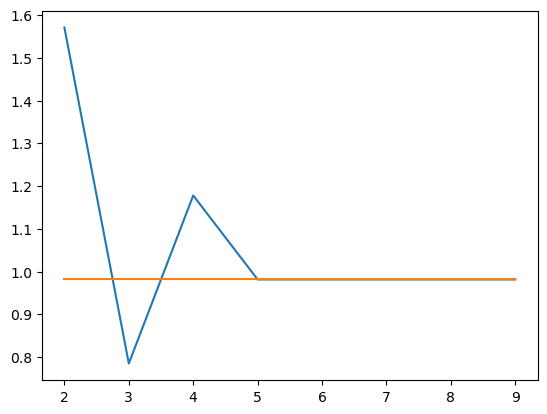

In [138]:
input_angle = 2**-2 + 2**-4
precisions = np.arange(2,10)
data = [get_estimate(input_angle, precision) for precision in precisions]
plt.plot(precisions, data)
plt.plot(precisions, input_angle*np.pi*(1+np.zeros_like(precisions)))
plt.show()

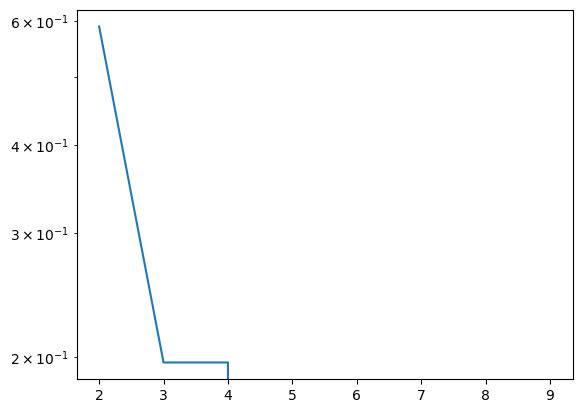

In [139]:
plt.plot(precisions, np.abs(data-input_angle*np.pi*(1+np.zeros_like(precisions))))
plt.yscale('log')
plt.show()

In [54]:
IQPE.get_final_estimate(), input_angle*np.pi

(4.558990901596125, 1.2566370614359172)

# Bayesian QPE

In [166]:
import numpy as np

class alpha_phase_estimation():
    """
    A class to perform alpha phase estimation algorithm.
    
    This class estimates the phase of a quantum state using the iterative phase estimation algorithm. 
    The algorithm iteratively refines the estimate of the phase by adjusting the measurement basis 
    and interpreting the measurement outcomes.
    
    Attributes:
        M_0 (int): Initial value of M, controls the precision of the phase estimation.
        z_angle_0 (float): Initial z-axis rotation angle.
        precision (int): The number of bits of precision for the phase estimate.
        backend: The quantum computation backend to run circuits.
    """

    def __init__(self, mu=None, sigma=None, s=100, precision=3, backend=None):
        """
        Initializes the iterative phase estimation algorithm with optional parameters.
        
        Parameters:
            M_0 (int, optional): The starting value of M. Defaults to 2**(precision-1) if None.
            z_angle_0 (float, optional): The starting z-axis angle for rotation. Defaults to 0 if None.
            precision (int, optional): The desired precision for the phase estimate. Defaults to 3.
            backend: The backend to execute quantum circuits. Defaults to None.
        """
        self.mu = mu if mu is not None else 2**(precision-1)
        self.sigma = sigma if sigma is not None else 0.
        self.mu_list = [self.mu]  # Tracks the M values used in each iteration.
        self.sigma_list = [self.sigma]  # Tracks the angles used in each iteration.
        self.precision = precision
        self.phi_list = []  # Tracks the phi values obtained in each iteration.
        self.backend = backend
        self.phi_arr = np.linspace(0, 1, 2**precision)
        self.pdist = np.exp(-0.5*((self.phi_arr - self.mu) / self.sigma)**2)
        self.pdist /= np.sum(self.pdist)
        self.s = s

    def next_dist(self, phi):
        """
        Calculates the next parameters (M and angle) for the iteration based on the latest phi value.
        
        Parameters:
            phi (int): The phi value obtained from the latest quantum measurement.
        
        Returns:
            tuple: A tuple containing the new M value and the new angle for the next iteration.
        """
        last_M, last_angle = self.mu_list[-1], self.sigma_list[-1]

        # Compute the mean
        new_mu = np.sum(self.phi_arr * self.pdist)

        # Compute the standard deviation
        variance = np.sum((self.phi_arr - new_mu)**2 * self.pdist)
        new_sigma = np.sqrt(variance)

        self.mu_list.append(new_mu)
        self.sigma_list.append(new_sigma)

        return new_mu, new_sigma

    def params(self):
        mu, sigma = self.mu_list[-1], self.sigma_list[-1]
        M = int(1.25/sigma)
        angle = mu-sigma
        return M, angle

    def next_phi(self, circuit):
        """
        Processes the given circuit to extract the next phi value.
        
        This method involves compiling the circuit for the backend, executing it, 
        and interpreting the result to obtain phi.
        
        Parameters:
            circuit: The quantum circuit to be processed.
        
        Returns:
            int: The new phi value extracted from the circuit execution result.
        """
        # Assuming DecomposeBoxes is a method or class available in the context for circuit processing.
        DecomposeBoxes().apply(circuit)
        compiled_circ = self.backend.get_compiled_circuit(circuit)
        n_shots = self.s  # The number of shots for the circuit execution.
        result = self.backend.run_circuit(compiled_circ, n_shots)

        for key, val in result.get_counts().items():
            meas = key[1]
            if meas==0:
                P_0 = val/n_shots
                P_1 = 1-P_0
            elif meas==1:
                P_1 = val/n_shots
                P_0 = 1-P_1
        #print(P_0, P_1)
        #new_phi = list(result.get_counts())[0][1]  # Assuming specific format for result interpretation.
        self.prob_theo(P_0)

    def prob_theo(self, P_0):
        last_M, last_angle = self.params()
        factor = 2*P_0 - 1
        print(last_angle)
        likelihood = (1 + factor*np.cos(last_M * (last_angle - self.phi_arr))) / 2
        self.pdist *= likelihood
        self.pdist /= np.sum(self.pdist)

    def get_final_estimate(self):
        """
        Calculates the final phase estimate after all iterations.
        
        Returns:
            float: The final estimate of the phase.
        """
        precision = self.precision
        
        final_angle = self.mu_list[-1]
        self.final_angle = final_angle
        return final_angle


In [167]:
def get_estimate_alpha(input_angle, precision):
    AQPE = alpha_phase_estimation(mu=0.25, sigma=0.1, s=1, precision=precision, backend=backend)
    for i in range(2):
        M, angle = AQPE.params()
        M = 1
        m = int(log2(M))
        print(M, angle, m)
        print(AQPE.pdist)
        plt.plot(AQPE.phi_arr, AQPE.pdist)
        circuit = bayesian_qpe_builder(1, 1, input_angle=input_angle, z_angle=angle, m=m).bayesian_qpe_circ.measure_all()
        phi = AQPE.next_phi(circuit)
        print(AQPE.pdist)
        if i < 2 - 1:
            AQPE.next_dist(phi)
    return AQPE.get_final_estimate()
plt.show()

In [161]:
render_circuit_jupyter(circuit)

1 0.15 0
[1.72397960e-04 1.76654470e-04 1.80998777e-04 ... 2.77183019e-15
 2.57625648e-15 2.39425319e-15]
0.15
[2.58255692e-04 2.62165385e-04 2.66078720e-04 ... 5.85513129e-15
 5.41665731e-15 5.01014032e-15]
1 0.2344649752432667 0
[2.58255692e-04 2.62165385e-04 2.66078720e-04 ... 5.85513129e-15
 5.41665731e-15 5.01014032e-15]
0.2344649752432667
[5.84939247e-04 5.94340381e-04 6.03709805e-04 ... 8.66784864e-15
 7.93810558e-15 7.26746688e-15]


0.32018171506128484

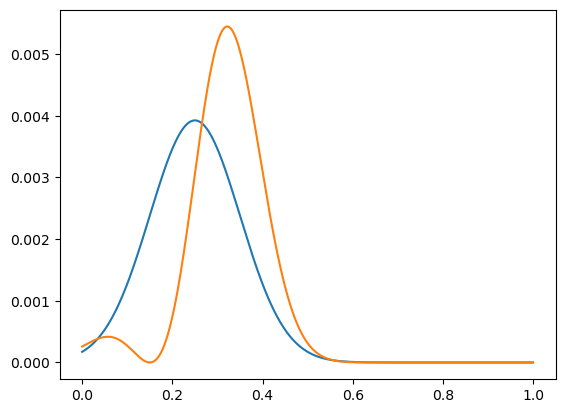

In [168]:
get_estimate_alpha(0.3, 10)